# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [2]:
from matplotlib import pyplot as plt
import xupy as xp
import numpy as np
import sympy as sp
import skimage as si
import poppy
import grasp
gplt = grasp.plots


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 5080 Laptop GPU`
[XuPy] Memory = 16231.04 MB | Compute Capability = 12.0
[XuPy] Using CuPy 13.5.1 for acceleration.


/home/pietrof/miniforge3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## The simulator

The idea of the `SimulatorV0` is to simply create a map of close point-like sources, spanning different angles and separations, to convolve with a constructed (very simplified) _Gaia_ PSF (created with `Poppy`)

### The Poppy optical system

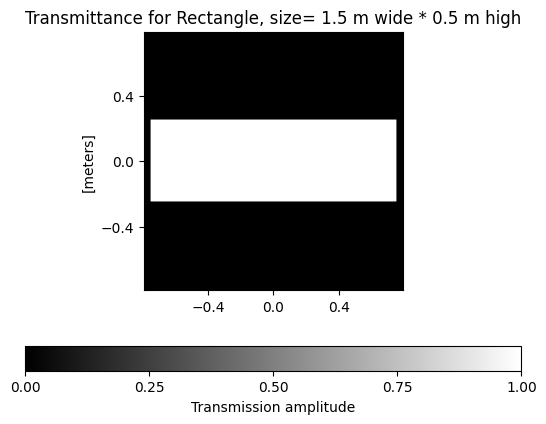

In [3]:
## template for GAIA PSF
import poppy
import astropy.units as u
osys = poppy.OpticalSystem()

#parameters
#off axis == no secondary obstruction
apert_w = 1.5 #m
apert_h = 0.5 #m
pixscale_x = 0.05
pscale_fact = 2 #pixscale_y/pixscale_x
pixscale_y = pixscale_x*pscale_fact
field_ofview = 5 #arcsec
wavel_pfs = 550e-9

optic = poppy.RectangleAperture(width=apert_w*u.m, height=apert_h*u.m)
osys.add_pupil(optic)
osys.display()

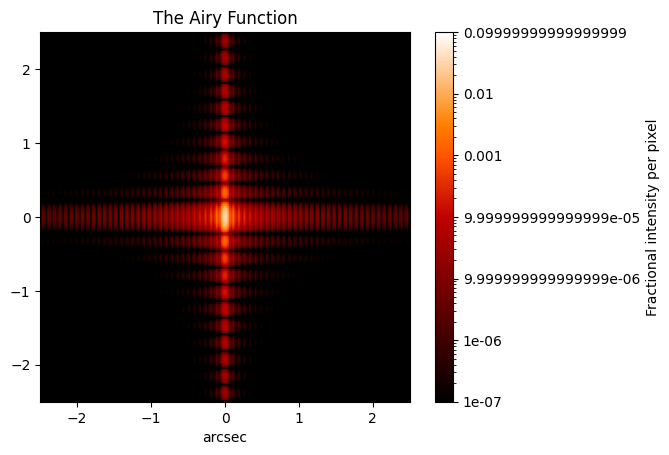

In [4]:
osys.add_detector(pixelscale=pixscale_x, fov_arcsec=field_ofview)  # image plane coordinates in arcseconds
psf_hud = osys.calc_psf(wavel_pfs)                            # wavelength in meters
poppy.display_psf(psf_hud, title='The Airy Function')
img = psf_hud[0].data
psf = poppy.utils.rebin_array(img, (1,pscale_fact))

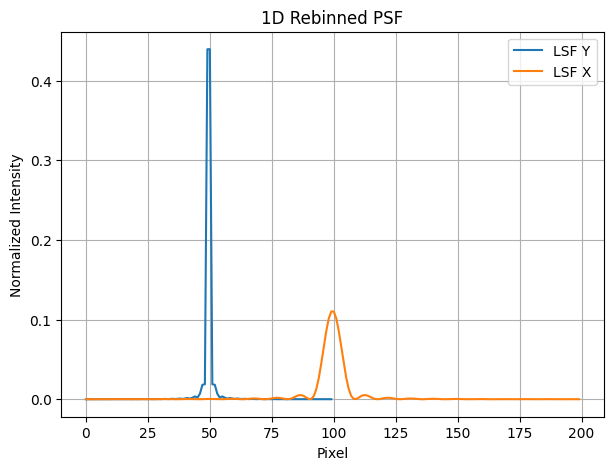

In [5]:
lsf_y = np.sum(psf, axis=0)  # or axis=1, depending on scan direction
lsf_y /= np.sum(lsf_y)  # normalize

lsf_x = np.sum(psf, axis=1)  # or axis=0, depending on scan direction
lsf_x /= np.sum(lsf_x)  # normalize

plt.figure(figsize=(7, 5))
plt.title('1D Rebinned PSF')
plt.plot(lsf_y  , label='LSF Y')
plt.plot(lsf_x, label='LSF X')
plt.xlabel('Pixel')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid()
plt.show()

So, now we have a LSF resembling that of Gaia, that we have to convolve with the produced map of sources

In [6]:
from astropy import convolution

In [7]:
# Simulate a star with Poisson noise
flux = 120  # total counts for the star
background = 5  # mean background
sky_map = np.random.poisson(background, (128, 128))
sky_map[sky_map.shape[0]//2, sky_map.shape[1]//2] += flux

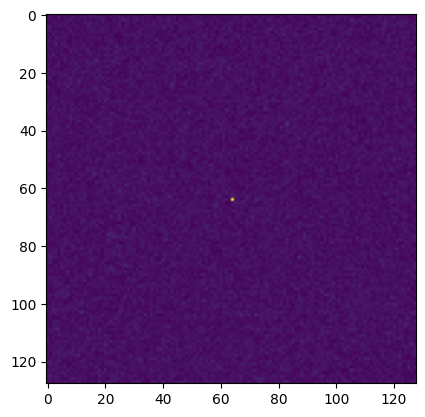

In [8]:
plt.imshow(sky_map)

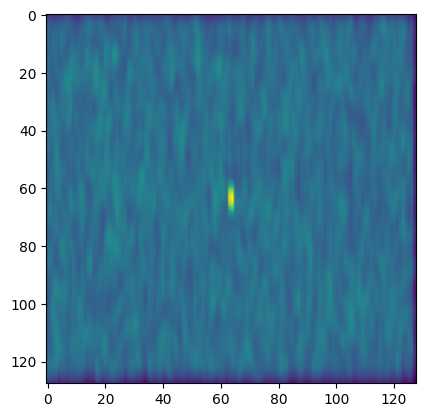

In [9]:
plt.imshow(convolution.convolve_fft(sky_map, psf, normalize_kernel=False))

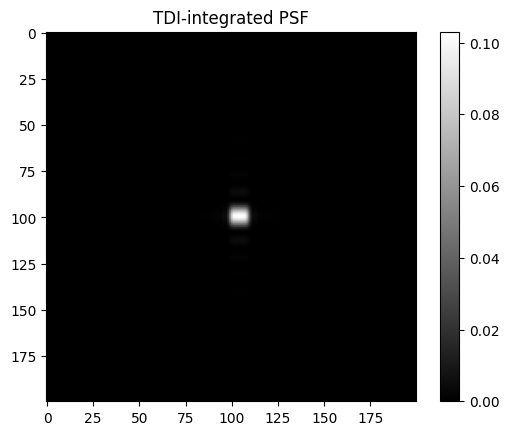

In [ ]:
def TDI_integration(psf_img, n_steps, direction='x'):
    """
    Integrate the PSF measurement using Time Delay Integration (TDI).
    
    Parameters:
    -----------
    psf_img : 2D array
        The PSF image to be integrated.
    n_steps : int
        The number of TDI steps to simulate.
    direction : str
        The direction of the scan ('x' or 'y').
        
    Returns:
    --------
    tdi_img : 2D array
        The TDI-integrated image.
    """
    tdi_img = np.zeros_like(psf_img)
    # Compute the amount of pixel shifted based on the speed and 
    # pixel scale
    # ...
    for i in range(n_steps):
        if direction == 'x':
            shifted = np.roll(psf_img, shift=i, axis=1)
        else:
            shifted = np.roll(psf_img, shift=i, axis=0)
        tdi_img += shifted
    return tdi_img

# Example usage:
n_tdi_steps = 10  # Number of TDI steps (depends on scan speed and exposure)
tdi_psf = simulate_tdi(img, n_tdi_steps, direction='x')

plt.figure()
plt.title('TDI-integrated PSF')
plt.imshow(tdi_psf, cmap='gray')
plt.colorbar()

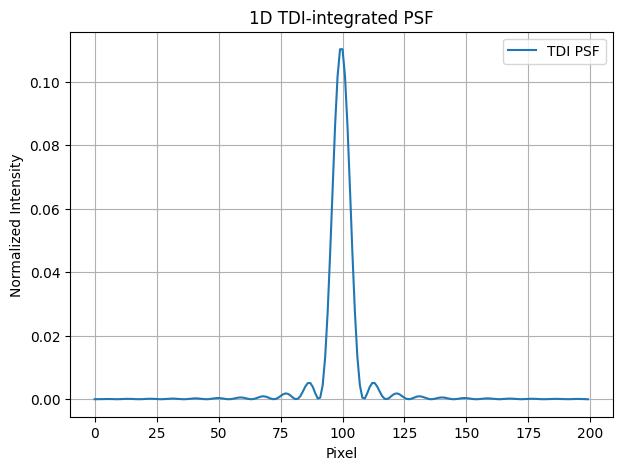

In [12]:
tdi_psf = np.sum(tdi_psf, axis=1)  # Sum over the TDI steps
tdi_psf /= np.sum(tdi_psf)  # Normalize

plt.figure(figsize=(7, 5))
plt.title('1D TDI-integrated PSF')
plt.plot(tdi_psf, label='TDI PSF')
plt.xlabel('Pixel')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid()
plt.show()

In [13]:
from scipy.ndimage import zoom

def resample_sky_to_detector(sky_map, sky_pixscale, detector_shape, detector_pixscale):
    """
    Resample the sky map to match the detector's pixel scale and shape.
    """
    scale_factor = sky_pixscale / detector_pixscale
    zoom_factors = (detector_shape[0] / sky_map.shape[0], detector_shape[1] / sky_map.shape[1])
    resampled_sky = zoom(sky_map, zoom_factors, order=1)
    return resampled_sky

# Example usage:
sky_pixscale = 0.01  # arcsec/pixel (sky map)
detector_pixscale = 0.05  # arcsec/pixel (poppy)
detector_shape = (128, 128)
resampled_sky = resample_sky_to_detector(sky_map, sky_pixscale, detector_shape, detector_pixscale)

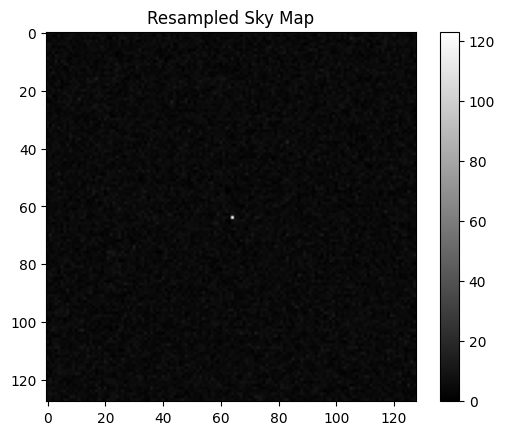

In [14]:
plt.figure()
plt.title('Resampled Sky Map')
plt.imshow(resampled_sky, cmap='gray')
plt.colorbar()
plt.show()